In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

## The Original U-Net Architecture

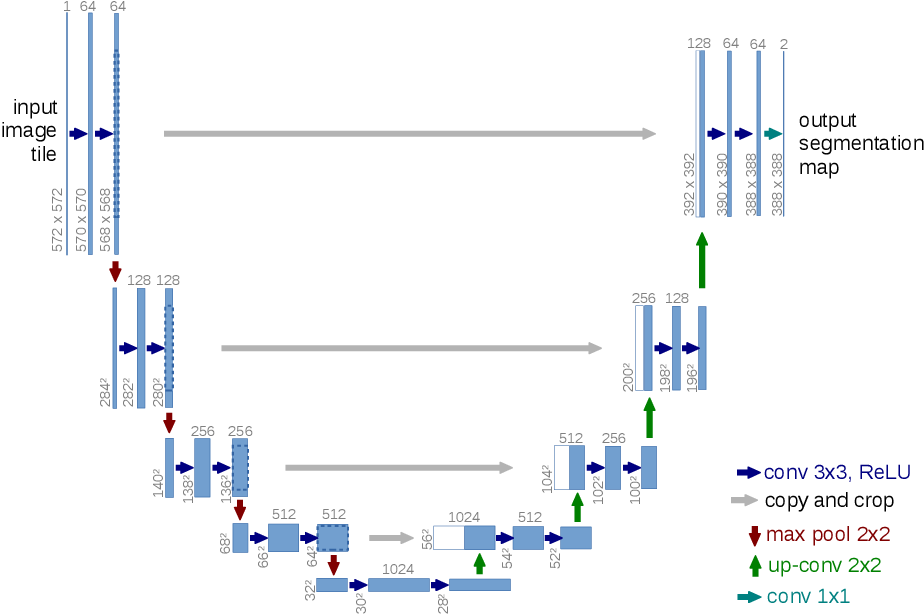

Defining the double convolution block:

In [27]:
def conv_block(ni, nf):
  return nn.Sequential(
      nn.Conv2d(ni, nf, kernel_size=3, stride=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(nf, nf, kernel_size=3, stride=1),
      nn.ReLU(inplace=True)
  )

Implementing the origal architecture:

In [36]:
class UNET(nn.Module):
  def __init__(self, in_channels=1, out_channels=1, 
               features = [64, 128, 256, 512]):
    super(UNET, self).__init__()

    self.encoder = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # create the contracting path (encoder + bottleneck)
    for feature in features:
      self.encoder.append(conv_block(in_channels, feature))
      in_channels = feature
    self.bottleneck = conv_block(features[-1], features[-1]*2)

    # create the expansive path
    self.decoder = nn.ModuleList()
    # reversed because we want to create from last to first
    for feature in reversed(features):
      self.decoder.append(
          nn.Sequential(
              nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2),
              conv_block(feature*2, feature)
          )
      )
      self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)


  def forward(self, x):
    activations = []
    
    # forward pass on the Encoder
    for module in self.encoder:
      x = module(x)
      activations.append(x)
      x = self.pool(x)
    x = self.bottleneck(x)

    # reverse the order of activations for easier usage
    activations.reverse()
    
    # forward pass on the decoder
    for idx in range(len(self.decoder)):
      # up scale first
      x = self.decoder[idx][0](x)
      # crop incoming activation
      activation = TF.resize(activations[idx], size=x.shape[2:])
      # concat
      x = torch.cat([activation, x], dim=1)
      # double conv
      x = self.decoder[idx][1](x)
    
    return self.final_conv(x)

52 lines of code is impresive!

In [37]:
UNET()

UNET(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0

Testing the U-Net with the original sizes of the input in the paper:

In [38]:
x = torch.randn(1, 1, 572, 572)
m = UNET(in_channels=1, out_channels=2)
m(x).shape

torch.Size([1, 2, 388, 388])

Does our U-Net also work for odd numbers?

In [39]:
x = torch.randn(1, 1, 571, 571)
m = UNET(in_channels=1, out_channels=2)
m(x).shape

torch.Size([1, 2, 372, 372])

## To-Do

*  Find a way to make U-Net Dynamic so that we don't have to use an image twice as bigger - I'm thinking using same convolutions on the `conv_block` and padding instead of cropping before concating.